<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/HW_04_Mini_Project_(seismic_image_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##HW #04 - Mini-Project (seismic image classification)

# Seismic Image Classification

### 1. Data loading

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Load data from google disk
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/AI Energy/'

# read npy format data
data = Path(r"C:\Users\에너지자원공학과\Desktop\Python\AI\AI-in-Engenery")
X_syn = np.load(path + 'synth_500_proc.npy')
X_fld = np.load(path + 'field_500_proc.npy')

# print(X_org.shape, Y_org.shape)
print(X_syn.shape)
print(X_fld.shape)

Mounted at /content/drive
(500, 128, 128)
(500, 128, 128)


500 — number of samples (individual 2D maps/images) <br>
128 — height (rows) of each map <br>
128 — width (columns) of each map

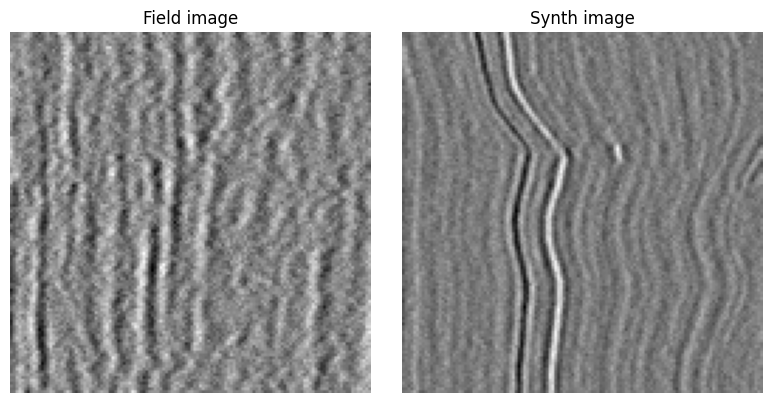

In [ ]:
# Visualize some images
data = np.load("field_500_proc.npy") # shape (500,128,128)
i = 0  # индекс нужной картинки

data1 = np.load("synth_500_proc.npy") # shape (500,128,128)
i = 0  # индекс нужной картинки

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(data[i], cmap='gray')
axes[0].set_title('Field image')
axes[0].axis('off')

axes[1].imshow(data1[i], cmap='gray')
axes[1].set_title('Synth image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_label_comp(data1, data2, image_index): # function visually compare two 2D images at the same index from different arrays

    fig, axes = plt.subplots(1, 2, figsize=(8, 4)) # 1 row, 2 columns

    # 첫 번째 subplot
    im1 = axes[0].imshow(np.transpose(data1[image_index]), cmap='gray_r', interpolation='none') # 'gray_r'는 흑백 반전 colormap
    axes[0].set_title('seismic image 1')

    # 첫 번째 subplot에 대한 colorbar (세로 크기 동일)
    divider1 = make_axes_locatable(axes[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    # 두 번째 subplot
    im2 = axes[1].imshow(np.transpose(data2[image_index]), cmap='gray_r', interpolation='none')
    axes[1].set_title('seismic image 2')

    # 두 번째 subplot에 대한 colorbar (세로 크기 동일)
    divider2 = make_axes_locatable(axes[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.tight_layout()
    plt.show()


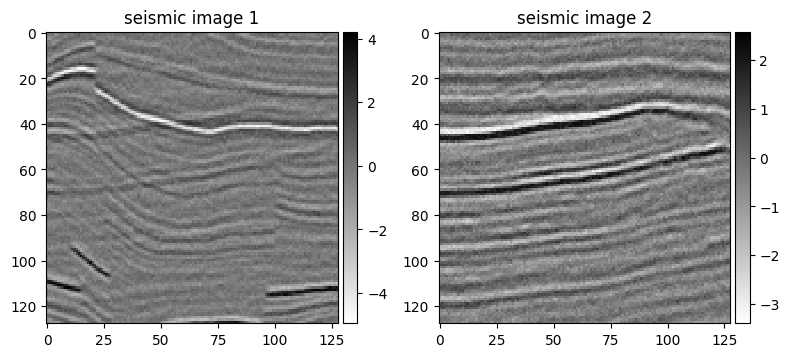

In [ ]:
plot_label_comp(X_syn, X_fld, 250) # compare 250-th image from both datasets

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

def npys_to_table(
    synth_path: str,
    field_path: str,
    save_csv: str = "combined_table.csv",
    feature_names: list[str] | None = None,
    make_numeric_label: bool = True,
    synthetic_name: str = "synthetic",
    field_name: str = "field",
    float_dtype = np.float32,
) -> pd.DataFrame:
    """
    Преобразует два .npy файла (synthetic и field) в единый табличный датасет:
    [features..., Label(строка), Label_id(число, опц.)] и сохраняет в CSV.

    - Поддерживает формы:
        (N, F) — без изменений
        (N,)   — → (N, 1)
        (N, d1, d2, ...) — → (N, d1*d2*...)
    """
    synth_p, field_p = Path(synth_path), Path(field_path)
    Xs = np.asarray(np.load(synth_p, allow_pickle=True))
    Xf = np.asarray(np.load(field_p, allow_pickle=True))

    # Приведение формы
    def _to_2d(x):
        if x.ndim == 1:
            return x.reshape(-1, 1)
        if x.ndim >= 3:
            return x.reshape(x.shape[0], -1)
        return x
    Xs, Xf = _to_2d(Xs), _to_2d(Xf)

    if Xs.shape[1] != Xf.shape[1]:
        raise ValueError(f"Несовместимые формы признаков: {Xs.shape[1]} vs {Xf.shape[1]}")

    # Имена признаков
    n_features = Xs.shape[1]
    if feature_names is None:
        feature_names = [f"f{i+1:02d}" for i in range(n_features)]  # f01, f02, ...

    # Типы
    Xs = Xs.astype(float_dtype, copy=False)
    Xf = Xf.astype(float_dtype, copy=False)

    # Таблицы и метки (строковые)
    df_synth = pd.DataFrame(Xs, columns=feature_names)
    df_synth["Label"] = synthetic_name
    df_field = pd.DataFrame(Xf, columns=feature_names)
    df_field["Label"] = field_name

    # Объединение
    df = pd.concat([df_synth, df_field], ignore_index=True)

    # Числовая метка (опционально): 1=synthetic, 0=field
    if make_numeric_label:
        label_map = {synthetic_name: 1, field_name: 0}
        df["Label_id"] = df["Label"].map(label_map).astype("int64")

    # Сохранение
    df.to_csv(save_csv, index=False)
    print(df.head(), "\n")
    print(df["Label"].value_counts(), "\n")
    print(f"Saved -> {save_csv} | shape={df.shape}")

    return df


In [ ]:
# пути к вашим двум .npy
df = npys_to_table(
    "synth_500_proc.npy",
    "field_500_proc.npy",
    save_csv="my_dataset_table.csv",
    # если хотите свои названия классов:
    synthetic_name="synthetic",
    field_name="field",
)

# Быстрая проверка
print(df.dtypes)              # убедиться, что признаки числовые, Label строка
print(df["Label"].value_counts())


        f01       f02       f03       f04       f05       f06       f07  \
0 -1.161243 -1.161051 -1.224509 -0.605055 -0.106803  0.137175 -0.327901   
1 -0.181608 -0.473053 -0.433254 -0.129050 -0.355412 -1.105960 -0.600086   
2  0.014300  0.299920  0.285910  0.202444  0.400866  0.687009  0.614435   
3 -1.030151 -0.926235 -0.430353  0.338641  0.894853  0.378457 -0.410774   
4  0.584768 -0.716166 -0.113162 -0.310483 -0.152063 -0.506469 -0.340400   

        f08       f09       f10  ...    f16377    f16378    f16379    f16380  \
0 -0.786394 -1.083652 -0.484977  ... -0.261862 -0.269392 -0.254417 -0.646453   
1  0.563051  0.242252 -0.596080  ... -1.094301 -0.863761 -0.622072 -0.158502   
2  1.027561  0.559329  0.093082  ...  0.367756  0.935271  0.371407 -0.251516   
3 -0.901762 -0.210282 -0.605237  ... -0.356779 -0.694944 -0.302812  0.359104   
4  0.366207 -0.612640 -0.418754  ... -0.383941 -0.119102 -0.071884 -0.446153   

     f16381    f16382    f16383    f16384      Label  Label_id  
0 -

In [ ]:
# =========================
# Section 3. Split & Scale
# =========================

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ---------- A) если у вас DataFrame df ----------
# features = все столбцы кроме меток
feature_cols = [c for c in df.columns if c not in ("Label", "Label_id")]
X = df[feature_cols].to_numpy(dtype=np.float32)

# y_enc: предпочтительно использовать числовую метку Label_id (1=synthetic, 0=field)
if "Label_id" in df.columns:
    y_enc = df["Label_id"].to_numpy(dtype=np.int64)
else:
    # если осталась строковая метка — закодируем
    le = LabelEncoder()
    y_enc = le.fit_transform(df["Label"].to_numpy())
    print("Label mapping:", dict(zip(le.transform(le.classes_), le.classes_)))

# ---------- B) если у вас .npz набор ----------
# z = np.load("combined_dataset.npz", allow_pickle=True)
# X = z["X"].astype(np.float32, copy=False)
# y_enc = z["y"].astype(np.int64, copy=False)

# Разделение 80/20 с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, stratify=y_enc, random_state=42
)

print(f"Sample size: Training {X_train.shape}, Test {X_test.shape}\n")

# Масштабирование (fit только на train!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled (first 3 rows):\n", X_train_scaled[:3], "\n")

# Быстрая проверка стратификации
def dist(y):
    u, c = np.unique(y, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}
print("Class distribution — total:", dist(y_enc))
print("Class distribution — train:", dist(y_train))
print("Class distribution — test :", dist(y_test))

"""
We use train_test_split(*arrays, test_size=None, train_size=None,
random_state=None, shuffle=True, stratify=None) to split data 80/20.
Scaling with StandardScaler (fit on train, transform train/test) for MLP.
"""


Sample size: Training (800, 16384), Test (200, 16384)

Scaled (first 3 rows):
 [[-0.82254714 -0.70085835  0.7189608  ...  1.4364798  -0.03515678
  -1.3215537 ]
 [-1.3915132  -1.1071188  -1.0876507  ... -0.59062827 -0.9707716
  -0.95225453]
 [ 0.07246818 -0.8513171  -1.1919957  ...  0.13350245 -0.7222963
  -0.60677683]] 

Class distribution — total: {0: 500, 1: 500}
Class distribution — train: {0: 400, 1: 400}
Class distribution — test : {0: 100, 1: 100}


'\nWe use train_test_split(*arrays, test_size=None, train_size=None,\nrandom_state=None, shuffle=True, stratify=None) to split data 80/20.\nScaling with StandardScaler (fit on train, transform train/test) for MLP.\n'

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,753 (4.01 MB)

 Trainable params: 1,050,753 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5250 - auc: 0.6048 - loss: 2.2562 - val_accuracy: 0.5188 - val_auc: 0.6351 - val_loss: 2.7130 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7344 - auc: 0.8086 - loss: 1.1247 - val_accuracy: 0.4437 - val_auc: 0.5072 - val_loss: 2.6340 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8891 - auc: 0.9372 - loss: 0.4472 - val_accuracy: 0.5500 - val_auc: 0.6384 - val_loss: 2.5931 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - auc: 0.9780 - loss: 0.1948 - val_accuracy: 0.5437 - val_auc: 0.6553 - val_loss: 3.0602 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9656 - auc: 0.9876 - loss: 0.1391 - val_accuracy: 0.5188 - val_auc: 0.5928 - val_loss: 2.4686 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9281 - auc: 0.

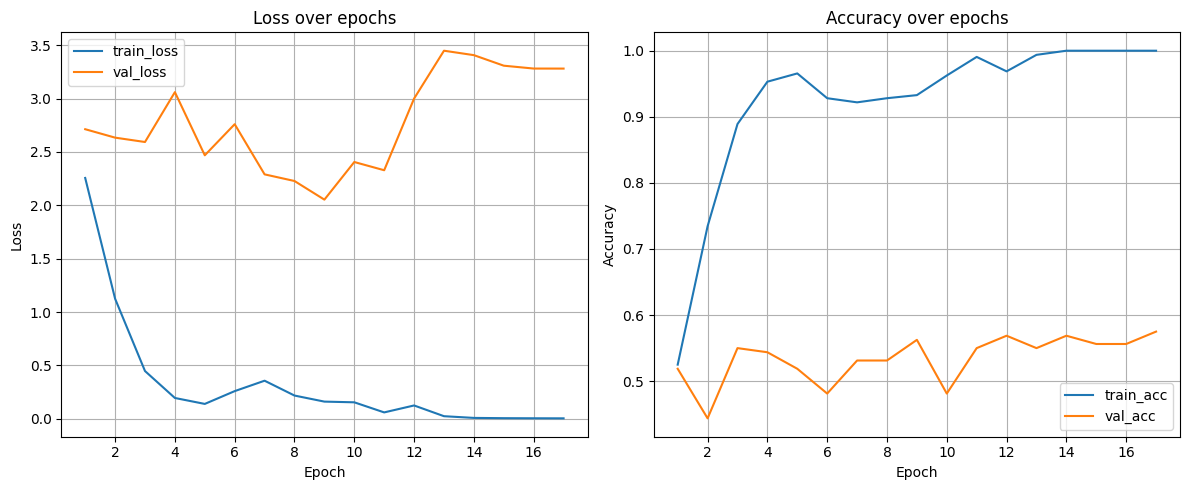

In [ ]:
# ==============================
# Section 4. MLP (TensorFlow/Keras)
# ==============================

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Фиксируем генераторы (по желанию)
tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_scaled.shape[1]
n_classes  = len(np.unique(y_train))

# Архитектура
hidden = [64, 32]  # можно менять

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(n_features,)))
model.add(keras.layers.Dense(hidden[0], activation='relu'))
model.add(keras.layers.Dense(hidden[1], activation='relu'))

# Выход и лосс — в зависимости от числа классов
if n_classes == 2:
    # бинарный случай (например: 0=field, 1=synthetic)
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    loss = 'binary_crossentropy'
    metrics = ['accuracy', keras.metrics.AUC(name='auc')]
else:
    # мультикласс (напр.: blasting/drilling/electric noise/microseismic/scaling)
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']

model.summary()

# Компиляция
model.compile(optimizer='adam', loss=loss, metrics=metrics)

# Коллбэки: ранняя остановка и уменьшение LR
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)
plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1
)

# Обучение (20% от train пойдут на валидацию)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, plateau],
    verbose=1
)

# Оценка на тесте
test_metrics = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# ====== Графики: Loss и Accuracy по эпохам ======
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, hist['loss'], label='train_loss')
plt.plot(epochs, hist['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over epochs')
plt.legend(); plt.grid(True)

# Accuracy (и val_accuracy, если есть)
plt.subplot(1,2,2)
plt.plot(epochs, hist['accuracy'], label='train_acc')
if 'val_accuracy' in hist:
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over epochs')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# (опционально) Сохранить модель
model.save('mlp_classifier.keras')


In [ ]:
test_results = model.evaluate(X_test_used, y_test, verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name:>10s}: {value:.4f}")

# Извлечём loss/accuracy для отдельной строки (если присутствуют)
test_loss = test_results[model.metrics_names.index("loss")]
test_acc  = test_results[model.metrics_names.index("accuracy")] \
            if "accuracy" in model.metrics_names else None
if test_acc is not None:
    print(f"\nTest — loss: {test_loss:.4f} | accuracy: {test_acc:.4f}")

# 5.2 Предсказания
proba = model.predict(X_test_used, verbose=0)
if n_classes == 2:
    y_pred = (proba.ravel() >= 0.5).astype(int)
else:
    y_pred = proba.argmax(axis=1)

# 5.3 Отчёт по классам
# Имена классов: если у вас известны человекочитаемые имена — замените
target_names = class_names if len(class_names) == len(classes_sorted) else None
print("\nClassification Report (MLP):")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# ROC-AUC для бинарного случая
if n_classes == 2:
    auc = roc_auc_score(y_test, proba.ravel())
    print(f"ROC-AUC: {auc:.4f}")

# 5.4 Матрица ошибок (counts)
cm = confusion_matrix(y_test, y_pred, labels=classes_sorted)
print("Confusion Matrix (counts):\n", cm)

plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names or classes_sorted)\
    .plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix — counts")
plt.tight_layout(); plt.show()

# 5.5 Нормированная по строкам матрица (доли)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names or classes_sorted)\
    .plot(cmap="Blues", values_format=".2f", colorbar=False)
plt.title("Confusion Matrix — row-normalized")
plt.tight_layout(); plt.show()


      loss: 1.2653
compile_metrics: 0.6350


NameError: name 'class_names' is not defined